In [1]:
from IPython.display import Image

## Quantum Machine Learning

## Variational Quantum Algorithms


The design and implementation of a VQA includes several steps:
<br>
- Selection of the cost function C($\theta$) corresponding to the solution of our problem
<br>
- Selection of the ansatz, or in other words the structure of our quantum circuit
<br>
- Decisions on how to encode the trainable parameters $\theta$
<br>
- Design and implementation of the functions that will encode feature mapping
<br>
- Decisions what the results will be used for (classification or further layers)
<br>
- Choice of the technique for the derivation of the cost function to calculate the
gradient of the quantum circuit
<br>
<br>
<div>
<img src="attachment:VAQ%20image.png" width="800"/>
</div>

Image taken from research paper Variational Quantum Algorithms<sup>1</sup>
<br>

Ansatz determines what the trainable parameters are and how they can be encoded in the quantum circuit. They can be:
- generic or problem specific
<br>
- fixed or dynamic (variational) like ADAPT-VQE
<br>
- only quantum or hybrid

<br>
<span id="fn1">1) https://arxiv.org/abs/2012.09265</span>


### Developing simple quantum classifier

We will create a circuit based on a number of entangled qubits and encode our parameters as amplitudes (angles). Based on the measurements, we will compare the result with the target labels, and calculate how much we need to adjust those amplitudes so to increase the probability of a correct prediction. 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit

from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

from qiskit.circuit import Parameter
from tqdm import tqdm

In [ ]:
NUM_QUBITS = 4
NUM_SHOTS = 10000
SHIFT = np.pi/2
LEARNING_RATE = 0.2
BACKEND = AerSimulator()
NUM_EPOCHS = 100
QC_OUTPUTS = ['0','1']

Next, we will define a class that will create a circuit and all necessary methods to execute it and obtain the results

In [14]:
class QiskitCircuit():
    """
    The class implements parameterized quantum circuit with num_qubit entangled qubits and
    encodes parameters in the angle of 'y' rotation operator with Ry gate
    """
    def __init__(self, num_qubits, backend, shots):
        self.circuit = qiskit.QuantumCircuit(num_qubits, 1)
        self.num_qubits = num_qubits
        self.backend = backend
        self.shots = shots
        self.thetas = {k: Parameter('Theta' + str(k)) for k in range(self.num_qubits)}

        self.circuit.h(0)
        for k in range(num_qubits - 1):
            self.circuit.cx(k, k + 1)

        self.circuit.barrier()
        for k in range(num_qubits):
            self.circuit.ry(self.thetas[k], k)
        self.circuit.barrier()

        for i in reversed(range(num_qubits - 1)):
            self.circuit.cx(i, i + 1)
        self.circuit.h(0)
        self.circuit.measure(0, 0)

    def expect_result(self, counts, shots):
        """
        This function takes the result of the experiment and gives as output the probability distribution
        """
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0) / shots
            expects[k] = perc
        return expects

    def run(self, params):
        """
        This function will receive the parameters and run the gates.
        It will collect the results and call 'expect_result' to obtain the probability distribution
        """
        # print('params = {}'.format(len(params)))
        
        pm = generate_preset_pass_manager(backend=self.backend, optimization_level=1)
        isa_qc = pm.run(self.circuit)
        with Session(backend=self.backend) as session:
            sampler = Sampler(mode=session)
            result = sampler.run([(isa_qc, params)]).result()

            pub_result = result[0]
            counts = pub_result.data.c.get_counts()




        result = self.expect_result(counts, self.shots)
        return result


Expected value for rotation ['pi/1', 'pi/2', 'pi/4', 'pi/8']: [0.051  0.0514]


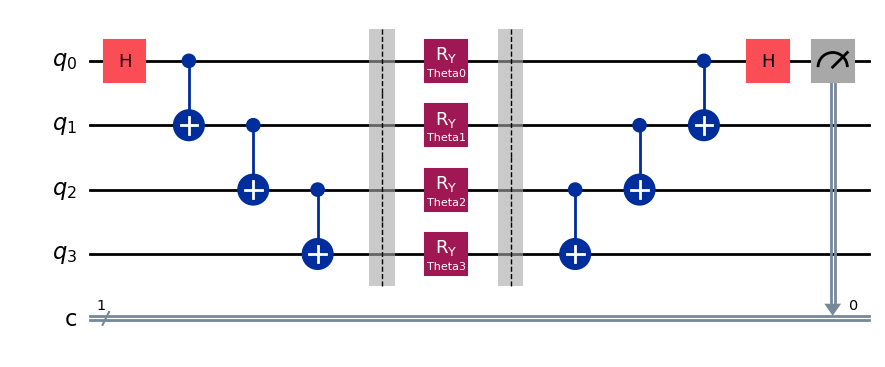

In [15]:
circuit = QiskitCircuit(NUM_QUBITS, BACKEND, NUM_SHOTS)
test_params = np.array([np.pi / 2**k for k in range(NUM_QUBITS)])
test_names = ['pi/{}'.format(2**k) for k in range (NUM_QUBITS)]
circuit_run = circuit.run(test_params)
print('Expected value for rotation {}: {}'.format(test_names, circuit_run))
circuit.circuit.draw(output='mpl')

### Gradient calculations

We will develop procedures for forward and backward pass for the calculation of prediction probabiliites and the circuit gradient

<br>
<div>
<img src="attachment:gradient%20of%20simple%20clf.png" width="850"/>
</div>
<br>


### Forward and backward pass functions

In [35]:
def get_initial_params(num_qubits):
    """
    We initialize the parameters to a value. It can be random initialization.
    These parameters will evolve over time being updated by the algorithm
    """
    q_params = [np.pi / 2 ** k for k in range(num_qubits)]
    return np.array(q_params)


def forward(num_qubits, backend, num_shots, q_params):
    """
    This is forward function, which calculates the output of the quantum circuit based on the input parameters
    It returns the probability distribution
    """
    circuit = QiskitCircuit(num_qubits, backend, num_shots)
    print('input_numbers = {}'.format(q_params))
    expectation = circuit.run(q_params)
    return expectation

def backward(num_qubits, backend, num_shots, q_params, d_loss):
    """
    This function performs the backpropagation by calculating the gradient of the quantum circuit with respect to its parameters,
    using parameter shift rule and multiplying it with the gradient of the loss function 'd_loss'
    """
    circuit = QiskitCircuit(num_qubits, backend, num_shots)
    q_grads = []
    for k in range(num_qubits):
        #*********************************************************
        #********* your cod here *********************************
        
        
        
        
        
        
        
        
        expectation_plus = 
        expectation_minus = 
        #***********************************************************
        q_grad = expectation_plus - expectation_minus
        q_grad_norm = q_grad / (np.linalg.norm(q_grad * 1.0)+(1e-09))
        q_grads.append(q_grad_norm[0])
    q_grads = np.array(q_grads)
    #print('q gradient = {}'.format(q_grads))
    dQ = d_loss * q_grads
    #print('total gradient = {}'.format(dQ))
    return dQ

def cost(num_qubits, simulator, num_shots, q_params):
    """
    This function performs the forward run producing the predictions, and calculates the loss function and the gradient of the loss function.
    It uses quadratic loss function
    """
    target = 1
    expval = forward(num_qubits, simulator, num_shots, q_params)
    print('predicted value = {}'.format(expval))
    val = sum([(i + 1) * expval[i] for i in range(2)]) / 2
    loss = (val - target) ** 2
    d_loss = val - target
    print('loss = {}'.format(loss))
    return loss, d_loss, expval


### Training and loss calculation

In [36]:
q_params = get_initial_params(NUM_QUBITS)
#print(q_params)

loss_list = []
expval_list = []

for i in tqdm(range(NUM_EPOCHS)):
    loss, d_loss, expval = cost(NUM_QUBITS, BACKEND, NUM_SHOTS, q_params)
    dQ = backward(NUM_QUBITS, BACKEND, NUM_SHOTS, q_params, d_loss)
    for i in range(NUM_QUBITS):
        q_params[i] += LEARNING_RATE * dQ[i]
    loss_list.append(loss)
    expval_list.append(expval[1])


  0%|          | 0/100 [00:00<?, ?it/s]

input_numbers = [3.14159265 1.57079633 0.78539816 0.39269908]
predicted value = [0.503 0.497]
loss = 0.06325225000000002


  1%|          | 1/100 [00:00<00:25,  3.85it/s]

input_numbers = [3.17716012 1.53522886 0.7498307  0.42826654]
predicted value = [0.4778 0.5222]
loss = 0.05707321


  3%|▎         | 3/100 [00:00<00:21,  4.47it/s]

input_numbers = [3.21094569 1.50144329 0.71604514 0.46205208]
predicted value = [0.4679 0.5321]
loss = 0.0547326025
input_numbers = [3.24403121 1.46835777 0.68295962 0.4951376 ]
predicted value = [0.4468 0.5532]
loss = 0.04990756000000002


  5%|▌         | 5/100 [00:01<00:20,  4.74it/s]

input_numbers = [3.27562474 1.43676424 0.65136609 0.52673113]
predicted value = [0.4273 0.5727]
loss = 0.0456463225
input_numbers = [3.30583942 1.40654956 0.62115142 0.55694581]


  6%|▌         | 6/100 [00:01<00:20,  4.64it/s]

predicted value = [0.4134 0.5866]
loss = 0.042724889999999995
input_numbers = [3.33507121 1.37731777 0.59191963 0.5861776 ]


  7%|▋         | 7/100 [00:01<00:19,  4.74it/s]

predicted value = [0.4113 0.5887]
loss = 0.0422919225
input_numbers = [3.36415451 1.34823447 0.6210029  0.6152609 ]
predicted value = [0.3942 0.6058]
loss = 0.03884841000000002


  9%|▉         | 9/100 [00:01<00:19,  4.74it/s]

input_numbers = [3.39202866 1.32036032 0.59312879 0.64313504]
predicted value = [0.3722 0.6278]
loss = 0.03463320999999998


 10%|█         | 10/100 [00:02<00:18,  4.79it/s]

input_numbers = [3.41834718 1.2940418  0.6194473  0.61681653]
predicted value = [0.3691 0.6309]
loss = 0.034058702499999996


 11%|█         | 11/100 [00:02<00:18,  4.81it/s]

input_numbers = [3.44444649 1.26794249 0.64554661 0.64291584]
predicted value = [0.3567 0.6433]
loss = 0.031808722500000004
input_numbers = [3.46966899 1.24271999 0.62032411 0.66813825]
predicted value = [0.3442 0.6558]
loss = 0.029618409999999974


 12%|█▏        | 12/100 [00:02<00:19,  4.59it/s]

input_numbers = [3.4940076  1.21838138 0.64466273 0.64379963]
predicted value = [0.3422 0.6578]
loss = 0.02927520999999997


 13%|█▎        | 13/100 [00:02<00:18,  4.63it/s]

input_numbers = [3.5182048  1.19418418 0.62046554 0.61960245]
predicted value = [0.3313 0.6687]
loss = 0.027439922500000026


 14%|█▍        | 14/100 [00:03<00:18,  4.64it/s]

input_numbers = [3.54163124 1.17075774 0.64389198 0.64302889]
predicted value = [0.3168 0.6832]
loss = 0.025090559999999994


 15%|█▌        | 15/100 [00:03<00:18,  4.66it/s]

input_numbers = [3.56403239 1.14835659 0.62149084 0.66543003]
predicted value = [0.3173 0.6827]
loss = 0.025169822499999987


 16%|█▌        | 16/100 [00:03<00:17,  4.69it/s]

input_numbers = [3.58646888 1.1259201  0.64392733 0.64299353]
predicted value = [0.302 0.698]
loss = 0.022801000000000005


 17%|█▋        | 17/100 [00:03<00:17,  4.66it/s]

input_numbers = [3.60782351 1.10456547 0.62257271 0.66434812]
predicted value = [0.2912 0.7088]
loss = 0.021199359999999987


 19%|█▉        | 19/100 [00:04<00:17,  4.73it/s]

input_numbers = [3.62841446 1.08397452 0.64316366 0.64375717]
predicted value = [0.2996 0.7004]
loss = 0.02244003999999998
input_numbers = [3.64959938 1.0627896  0.62197875 0.62257226]
predicted value = [0.2842 0.7158]
loss = 0.02019241


 20%|██        | 20/100 [00:04<00:16,  4.74it/s]

input_numbers = [3.66969535 1.04269363 0.60188277 0.6024763 ]
predicted value = [0.2844 0.7156]
loss = 0.020220839999999997


 21%|██        | 21/100 [00:04<00:20,  3.91it/s]

input_numbers = [3.68980547 1.02258351 0.58177266 0.58236623]
predicted value = [0.2808 0.7192]
loss = 0.019712160000000024


 22%|██▏       | 22/100 [00:04<00:20,  3.77it/s]

input_numbers = [3.70966103 1.00272795 0.60162822 0.60222179]
predicted value = [0.2691 0.7309]
loss = 0.018103702499999985


 23%|██▎       | 23/100 [00:05<00:19,  3.90it/s]

input_numbers = [3.72868927 0.98369971 0.58259998 0.62125003]
predicted value = [0.2684 0.7316]
loss = 0.018009639999999997


 24%|██▍       | 24/100 [00:05<00:19,  3.94it/s]

input_numbers = [3.74766801 0.96472096 0.60157872 0.60227129]
predicted value = [0.2615 0.7385]
loss = 0.01709556249999998


 25%|██▌       | 25/100 [00:05<00:19,  3.90it/s]

input_numbers = [3.72917717 0.94623012 0.62006957 0.62076207]
predicted value = [0.2643 0.7357]
loss = 0.017463622499999998


 26%|██▌       | 26/100 [00:05<00:18,  4.05it/s]

input_numbers = [3.74786601 0.92754129 0.60138073 0.60207323]
predicted value = [0.258 0.742]
loss = 0.016641


 27%|██▋       | 27/100 [00:06<00:18,  3.98it/s]

input_numbers = [3.72962265 0.90929793 0.58313738 0.58382988]
predicted value = [0.2522 0.7478]
loss = 0.01590121


 28%|██▊       | 28/100 [00:06<00:18,  3.88it/s]

input_numbers = [3.71178942 0.8914647  0.56530415 0.56599665]
predicted value = [0.2613 0.7387]
loss = 0.017069422499999983


 29%|██▉       | 29/100 [00:06<00:21,  3.24it/s]

input_numbers = [3.69331272 0.872988   0.54682745 0.54751995]
predicted value = [0.247 0.753]
loss = 0.015252249999999986


 30%|███       | 30/100 [00:07<00:19,  3.50it/s]

input_numbers = [3.67584718 0.85552246 0.52936191 0.53005441]
predicted value = [0.2447 0.7553]
loss = 0.014969522500000018


 31%|███       | 31/100 [00:07<00:18,  3.68it/s]

input_numbers = [3.65854428 0.83821956 0.51205901 0.51275151]
predicted value = [0.2304 0.7696]
loss = 0.013271040000000019


 32%|███▏      | 32/100 [00:07<00:19,  3.42it/s]

input_numbers = [3.64225254 0.82192782 0.49576727 0.49645977]
predicted value = [0.2292 0.7708]
loss = 0.013133159999999982


 33%|███▎      | 33/100 [00:08<00:23,  2.88it/s]

input_numbers = [3.62604565 0.80572093 0.47956038 0.48025288]
predicted value = [0.2225 0.7775]
loss = 0.012376562500000016


 34%|███▍      | 34/100 [00:08<00:24,  2.74it/s]

input_numbers = [3.61031253 0.78998781 0.46382725 0.46451975]
predicted value = [0.2132 0.7868]
loss = 0.011363559999999983


 35%|███▌      | 35/100 [00:08<00:21,  3.03it/s]

input_numbers = [3.59523701 0.77491229 0.44875174 0.44944424]
predicted value = [0.2094 0.7906]
loss = 0.010962090000000002


 36%|███▌      | 36/100 [00:09<00:20,  3.14it/s]

input_numbers = [3.58043019 0.76010547 0.43394492 0.43463742]
predicted value = [0.1997 0.8003]
loss = 0.009970022499999998


 37%|███▋      | 37/100 [00:09<00:18,  3.48it/s]

input_numbers = [3.56630927 0.74598455 0.419824   0.4205165 ]
predicted value = [0.193 0.807]
loss = 0.009312249999999984


 38%|███▊      | 38/100 [00:09<00:16,  3.70it/s]

input_numbers = [3.55266211 0.73233739 0.40617684 0.40686934]
predicted value = [0.1925 0.8075]
loss = 0.00926406249999999


 39%|███▉      | 39/100 [00:09<00:15,  3.95it/s]

input_numbers = [3.53905031 0.71872559 0.39256503 0.39325753]
predicted value = [0.1887 0.8113]
loss = 0.008901922499999987


 40%|████      | 40/100 [00:09<00:14,  4.08it/s]

input_numbers = [3.5257072  0.70538248 0.37922193 0.37991443]
predicted value = [0.1842 0.8158]
loss = 0.008482410000000013


 41%|████      | 41/100 [00:10<00:13,  4.26it/s]

input_numbers = [3.51268229 0.69235757 0.36619702 0.36688952]
predicted value = [0.1718 0.8282]
loss = 0.007378809999999996


 42%|████▏     | 42/100 [00:10<00:13,  4.22it/s]

input_numbers = [3.5005342  0.68020948 0.35404893 0.35474143]
predicted value = [0.1607 0.8393]
loss = 0.0064561224999999875


 43%|████▎     | 43/100 [00:10<00:13,  4.34it/s]

input_numbers = [3.48917099 0.66884627 0.34268572 0.34337822]
predicted value = [0.1613 0.8387]
loss = 0.0065044225


 44%|████▍     | 44/100 [00:10<00:12,  4.47it/s]

input_numbers = [3.47776536 0.65744064 0.33128009 0.33197259]
predicted value = [0.1558 0.8442]
loss = 0.006068410000000013


 45%|████▌     | 45/100 [00:11<00:12,  4.47it/s]

input_numbers = [3.46674864 0.64642392 0.32026336 0.32095587]
predicted value = [0.1506 0.8494]
loss = 0.005670089999999989


 46%|████▌     | 46/100 [00:11<00:11,  4.54it/s]

input_numbers = [3.45609961 0.63577489 0.30961434 0.31030684]
predicted value = [0.1472 0.8528]
loss = 0.00541696


 47%|████▋     | 47/100 [00:11<00:11,  4.51it/s]

input_numbers = [3.445691   0.62536628 0.29920572 0.29989823]
predicted value = [0.1382 0.8618]
loss = 0.004774809999999991


 48%|████▊     | 48/100 [00:11<00:11,  4.54it/s]

input_numbers = [3.43591878 0.61559406 0.28943351 0.29012601]
predicted value = [0.1344 0.8656]
loss = 0.00451583999999999


 50%|█████     | 50/100 [00:12<00:10,  4.69it/s]

input_numbers = [3.42641527 0.60609055 0.27992999 0.28062249]
predicted value = [0.1271 0.8729]
loss = 0.004038602499999999


 51%|█████     | 51/100 [00:12<00:10,  4.83it/s]

input_numbers = [3.41742794 0.59710322 0.27094267 0.27163517]
predicted value = [0.1206 0.8794]
loss = 0.0036360900000000024
input_numbers = [3.40890023 0.58857551 0.26241496 0.26310746]


 52%|█████▏    | 52/100 [00:12<00:09,  4.92it/s]

predicted value = [0.123 0.877]
loss = 0.00378225
input_numbers = [3.40020282 0.5798781  0.25371755 0.25441005]
predicted value = [0.1183 0.8817]
loss = 0.003498722499999991


 54%|█████▍    | 54/100 [00:12<00:09,  4.93it/s]

input_numbers = [3.39183775 0.57151303 0.24535247 0.24604497]
predicted value = [0.1069 0.8931]
loss = 0.0028569025
input_numbers = [3.38427877 0.56395405 0.2377935  0.238486  ]


 55%|█████▌    | 55/100 [00:13<00:09,  4.81it/s]

predicted value = [0.1082 0.8918]
loss = 0.002926809999999992
input_numbers = [3.37662788 0.55630316 0.23014261 0.23083511]


 56%|█████▌    | 56/100 [00:13<00:09,  4.81it/s]

predicted value = [0.1059 0.8941]
loss = 0.0028037025000000057
input_numbers = [3.36913962 0.5488149  0.22265434 0.22334685]
predicted value = [0.1016 0.8984]
loss = 0.002580640000000007


 57%|█████▋    | 57/100 [00:13<00:09,  4.72it/s]

input_numbers = [3.36195541 0.54163069 0.21547014 0.21616264]
predicted value = [0.0984 0.9016]
loss = 0.002420640000000002


 58%|█████▊    | 58/100 [00:13<00:08,  4.70it/s]

input_numbers = [3.35499748 0.53467276 0.20851221 0.20920471]
predicted value = [0.0919 0.9081]
loss = 0.002111402499999994


 59%|█████▉    | 59/100 [00:14<00:08,  4.61it/s]

input_numbers = [3.34849917 0.52817445 0.2020139  0.2027064 ]
predicted value = [0.0965 0.9035]
loss = 0.0023280625000000016


 60%|██████    | 60/100 [00:14<00:08,  4.64it/s]

input_numbers = [3.34167559 0.52135087 0.19519032 0.19588282]
predicted value = [0.0875 0.9125]
loss = 0.0019140625000000058


 61%|██████    | 61/100 [00:14<00:08,  4.71it/s]

input_numbers = [3.33548841 0.51516369 0.18900313 0.18969563]
predicted value = [0.0863 0.9137]
loss = 0.001861922500000002


 63%|██████▎   | 63/100 [00:14<00:07,  4.75it/s]

input_numbers = [3.32938608 0.50906135 0.1829008  0.1835933 ]
predicted value = [0.0814 0.9186]
loss = 0.0016564900000000057
input_numbers = [3.32363023 0.50330551 0.17714495 0.17783745]
predicted value = [0.0808 0.9192]
loss = 0.0016321599999999993


 64%|██████▍   | 64/100 [00:15<00:07,  4.71it/s]

input_numbers = [3.3179168  0.49759208 0.17143153 0.17212403]
predicted value = [0.077 0.923]
loss = 0.0014822499999999983


 66%|██████▌   | 66/100 [00:15<00:07,  4.78it/s]

input_numbers = [3.31247208 0.49214736 0.16598681 0.16667931]
predicted value = [0.079 0.921]
loss = 0.0015602499999999985


 67%|██████▋   | 67/100 [00:15<00:06,  4.81it/s]

input_numbers = [3.30688594 0.48656122 0.16040066 0.16109316]
predicted value = [0.0807 0.9193]
loss = 0.0016281224999999998
input_numbers = [3.30117959 0.48085486 0.15469431 0.15538681]
predicted value = [0.0725 0.9275]
loss = 0.0013140625000000003


 69%|██████▉   | 69/100 [00:16<00:06,  4.90it/s]

input_numbers = [3.29605306 0.47572834 0.14956779 0.15026029]
predicted value = [0.0665 0.9335]
loss = 0.0011055625000000002
input_numbers = [3.2913508  0.47102608 0.14486553 0.14555803]


 70%|███████   | 70/100 [00:16<00:06,  4.88it/s]

predicted value = [0.0661 0.9339]
loss = 0.0010923025000000015
input_numbers = [3.28667683 0.4663521  0.14019155 0.14088405]


 71%|███████   | 71/100 [00:16<00:06,  4.66it/s]

predicted value = [0.0645 0.9355]
loss = 0.0010400625
input_numbers = [3.28211599 0.46179127 0.13563071 0.13632321]


 72%|███████▏  | 72/100 [00:16<00:06,  4.66it/s]

predicted value = [0.0648 0.9352]
loss = 0.001049759999999999
input_numbers = [3.27753394 0.45720921 0.13104866 0.13174116]


 73%|███████▎  | 73/100 [00:16<00:05,  4.66it/s]

predicted value = [0.0595 0.9405]
loss = 0.0008850624999999966
input_numbers = [3.27332665 0.45300193 0.12684138 0.12753388]


 74%|███████▍  | 74/100 [00:17<00:05,  4.68it/s]

predicted value = [0.0606 0.9394]
loss = 0.0009180899999999997
input_numbers = [3.26904158 0.44871686 0.12255631 0.12324881]


 75%|███████▌  | 75/100 [00:17<00:05,  4.71it/s]

predicted value = [0.0619 0.9381]
loss = 0.0009579024999999951
input_numbers = [3.26466459 0.44433987 0.11817932 0.11887182]
predicted value = [0.0551 0.9449]
loss = 0.0007590025000000041


 76%|███████▌  | 76/100 [00:17<00:05,  4.57it/s]

input_numbers = [3.26076843 0.44044371 0.11428316 0.11497566]
predicted value = [0.0575 0.9425]
loss = 0.0008265624999999967


 77%|███████▋  | 77/100 [00:17<00:04,  4.67it/s]

input_numbers = [3.25670257 0.43637785 0.1102173  0.1109098 ]
predicted value = [0.0548 0.9452]
loss = 0.0007507599999999989


 78%|███████▊  | 78/100 [00:18<00:04,  4.61it/s]

input_numbers = [3.25282762 0.4325029  0.10634235 0.10703485]
predicted value = [0.0537 0.9463]
loss = 0.0007209224999999962


 79%|███████▉  | 79/100 [00:18<00:04,  4.51it/s]

input_numbers = [3.24903046 0.42870574 0.10254519 0.10323769]
predicted value = [0.0527 0.9473]
loss = 0.0006943224999999992


 80%|████████  | 80/100 [00:18<00:04,  4.40it/s]

input_numbers = [3.24530401 0.42497929 0.09881873 0.09951124]
predicted value = [0.0509 0.9491]
loss = 0.0006477024999999987


 81%|████████  | 81/100 [00:18<00:04,  4.44it/s]

input_numbers = [3.24170483 0.42138011 0.09521956 0.09591206]
predicted value = [0.05 0.95]
loss = 0.0006250000000000011


 82%|████████▏ | 82/100 [00:19<00:04,  4.40it/s]

input_numbers = [3.2381693  0.41784458 0.09168403 0.09237653]
predicted value = [0.0522 0.9478]
loss = 0.0006812100000000007


 83%|████████▎ | 83/100 [00:19<00:03,  4.33it/s]

input_numbers = [3.2344782  0.41415348 0.08799293 0.08868543]
predicted value = [0.0517 0.9483]
loss = 0.0006682224999999963


 84%|████████▍ | 84/100 [00:19<00:03,  4.37it/s]

input_numbers = [3.23082246 0.41049774 0.08433719 0.08502969]
predicted value = [0.0523 0.9477]
loss = 0.0006838225000000003


 85%|████████▌ | 85/100 [00:19<00:03,  4.38it/s]

input_numbers = [3.22712429 0.40679957 0.08063902 0.08133152]
predicted value = [0.044 0.956]
loss = 0.00048400000000000087


 86%|████████▌ | 86/100 [00:19<00:03,  4.23it/s]

input_numbers = [3.22401302 0.4036883  0.07752775 0.07822025]
predicted value = [0.0463 0.9537]
loss = 0.0005359225000000002


 87%|████████▋ | 87/100 [00:20<00:03,  4.20it/s]

input_numbers = [3.22073912 0.4004144  0.07425385 0.07494635]
predicted value = [0.0428 0.9572]
loss = 0.0004579599999999989


 88%|████████▊ | 88/100 [00:20<00:02,  4.32it/s]

input_numbers = [3.2177127  0.39738798 0.07122743 0.07191993]
predicted value = [0.0427 0.9573]
loss = 0.00045582249999999913


 89%|████████▉ | 89/100 [00:20<00:02,  4.31it/s]

input_numbers = [3.21469336 0.39436863 0.06820808 0.06890058]
predicted value = [0.0426 0.9574]
loss = 0.0004536899999999994


 90%|█████████ | 90/100 [00:20<00:02,  4.41it/s]

input_numbers = [3.21168108 0.39135636 0.06519581 0.06588831]
predicted value = [0.039 0.961]
loss = 0.0003802500000000028


 91%|█████████ | 91/100 [00:21<00:02,  4.31it/s]

input_numbers = [3.20892336 0.38859864 0.06243809 0.06313059]
predicted value = [0.0421 0.9579]
loss = 0.00044310250000000056


 92%|█████████▏| 92/100 [00:21<00:01,  4.36it/s]

input_numbers = [3.20594645 0.38562172 0.05946117 0.06015367]
predicted value = [0.0378 0.9622]
loss = 0.00035720999999999686


 93%|█████████▎| 93/100 [00:21<00:01,  4.49it/s]

input_numbers = [3.20327358 0.38294886 0.05678831 0.05748081]
predicted value = [0.0366 0.9634]
loss = 0.00033488999999999936


 94%|█████████▍| 94/100 [00:21<00:01,  4.48it/s]

input_numbers = [3.20068557 0.38036085 0.0542003  0.0548928 ]
predicted value = [0.0379 0.9621]
loss = 0.00035910250000000085


 95%|█████████▌| 95/100 [00:21<00:01,  4.34it/s]

input_numbers = [3.19800564 0.37768091 0.05152036 0.05221286]
predicted value = [0.0356 0.9644]
loss = 0.0003168399999999974


 96%|█████████▌| 96/100 [00:22<00:00,  4.46it/s]

input_numbers = [3.19548834 0.37516361 0.04900306 0.04969556]
predicted value = [0.0356 0.9644]
loss = 0.0003168399999999974


 97%|█████████▋| 97/100 [00:22<00:00,  4.44it/s]

input_numbers = [3.19297104 0.37264631 0.04648576 0.04717826]
predicted value = [0.0384 0.9616]
loss = 0.0003686399999999998


 98%|█████████▊| 98/100 [00:22<00:00,  4.18it/s]

input_numbers = [3.19025575 0.36993102 0.04377047 0.04446297]
predicted value = [0.0354 0.9646]
loss = 0.0003132899999999978


 99%|█████████▉| 99/100 [00:23<00:00,  3.91it/s]

input_numbers = [3.18775259 0.36742787 0.04126731 0.04195982]
predicted value = [0.0377 0.9623]
loss = 0.00035532249999999706


100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


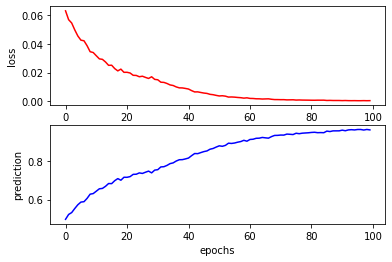

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(loss_list, 'r')
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")

ax2.plot(expval_list, 'b')
ax2.set_xlabel('epochs')
ax2.set_ylabel('prediction')

plt.show()